In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd

bitcoin_time_series = pd.read_csv("drive/MyDrive/File Skripsi/data_bitcoinity_full_daily.csv", parse_dates = ['Time'])

In [ ]:
gtrend_time_series = pd.read_csv("drive/MyDrive/File Skripsi/daily_gtrend_data.csv", parse_dates = ['date'])

In [ ]:
dataset = bitcoin_time_series.copy()
dataset['gtrend'] = gtrend_time_series['bitcoin']

In [ ]:
dataset.corr()

,price,volume,gtrend
price,1.000000,0.776318,0.658941
volume,0.776318,1.000000,0.868976
gtrend,0.658941,0.868976,1.000000


In [ ]:
del gtrend_time_series
del bitcoin_time_series

In [ ]:
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
#find design matrix for linear regression model using 'rating' as response variable 
y, X = dmatrices('price ~ volume+gtrend', data=dataset, return_type='dataframe')

In [ ]:
vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['variable'] = X.columns

In [ ]:
vif

,VIF,variable
0,1.357698,Intercept
1,4.083625,volume
2,4.083625,gtrend


In [ ]:
dataset.tail()

,Time,price,volume,gtrend
4031,2021-07-30 00:00:00+00:00,39659.762217,1.379564e+09,10.0
4032,2021-07-31 00:00:00+00:00,41630.200677,8.353289e+08,10.0
4033,2021-08-01 00:00:00+00:00,41465.818597,1.098162e+09,10.0
4034,2021-08-02 00:00:00+00:00,39617.942317,9.836454e+08,11.0
4035,2021-08-03 00:00:00+00:00,38499.216452,1.134831e+09,9.0


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import warnings
warnings.filterwarnings('ignore')
from scipy import stats
%matplotlib inline
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, layers, callbacks
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional

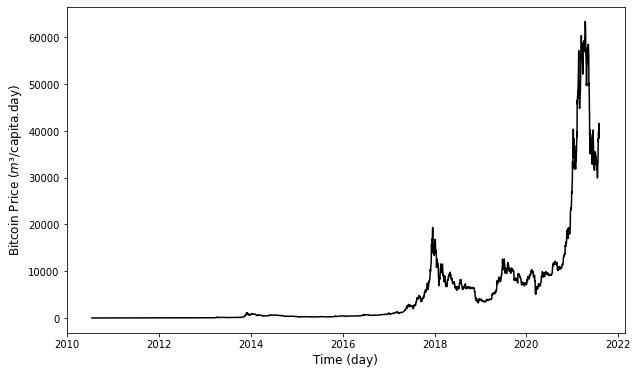

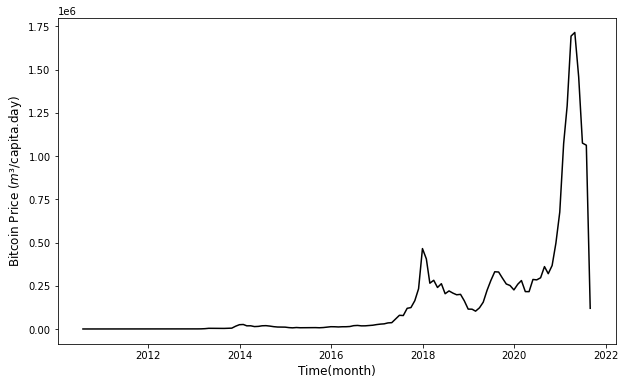

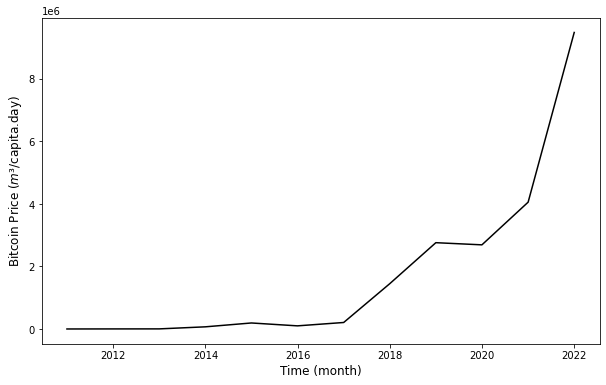

In [ ]:
def timeseries (x_axis, y_axis, x_label):
    plt.figure(figsize = (10, 6))
    plt.plot(x_axis, y_axis, color ='black')
    plt.xlabel(x_label, {'fontsize': 12}) 
    plt.ylabel('Bitcoin Price ($m³$/capita.day)', 
                                  {'fontsize': 12})
dataset_to_plt = dataset.copy()
dataset_to_plt = dataset_to_plt.set_index('Time')
timeseries(dataset_to_plt.index, dataset_to_plt['price'], 'Time (day)')
dataset_to_plt['month'] = dataset_to_plt.index.month
dataset_by_month = dataset_to_plt.resample('M').sum()
timeseries(dataset_by_month.index, dataset_by_month['price'], 
           'Time(month)')
dataset_to_plt['year'] = dataset_to_plt.index.year
dataset_by_year = dataset_to_plt.resample('Y').sum()
timeseries(dataset_by_year.index, dataset_by_year['price'], 
           'Time (month)')

In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4036 entries, 0 to 4035
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype              
---  ------  --------------  -----              
 0   Time    4036 non-null   datetime64[ns, UTC]
 1   price   4036 non-null   float64            
 2   volume  4036 non-null   float64            
 3   gtrend  4036 non-null   float64            
dtypes: datetime64[ns, UTC](1), float64(3)
memory usage: 126.2 KB


In [ ]:
# Check for missing values
print('Total num of missing values:') 
print(dataset.price.isna().sum())
print('')
# Locate the missing value
df_missing_date = dataset.loc[dataset.price.isna() == True]
print('The date of missing value:')
print(df_missing_date.loc[:,['Time']])
# Replcase missing value with interpolation
dataset.price.interpolate(inplace = True)
# Keep WC and drop Date
dataset = dataset.drop('Time', axis = 1)

Total num of missing values:
0

The date of missing value:
Empty DataFrame
Columns: [Time]
Index: []


In [ ]:
# Split train data and test data
train_size = int(len(dataset)*0.8)
print('Sequence length: ', int(len(dataset)))
print(train_size)

train_data = dataset.iloc[:train_size]
test_data = dataset.iloc[train_size:]

Sequence length:  4036
3228


In [ ]:
#Scaling with Min Max
scaler = MinMaxScaler().fit(train_data)
train_scaled = scaler.transform(train_data)
test_scaled = scaler.transform(test_data)

In [ ]:
# Create input dataset
def create_dataset (X, look_back = 1):
    Xs, ys = [], []
 
    for i in range(len(X)-look_back):
        v = X[i:i+look_back]
        Xs.append(v)
        ys.append(X[i+look_back])
 
    return np.array(Xs), np.array(ys)
LOOK_BACK = 30
X_train, y_train = create_dataset(train_scaled,LOOK_BACK)
X_test, y_test = create_dataset(test_scaled,LOOK_BACK)
# Print data shape
print('X_train.shape: ', X_train.shape)
print('y_train.shape: ', y_train.shape)
print('X_test.shape: ', X_test.shape) 
print('y_test.shape: ', y_test.shape)

X_train.shape:  (3198, 30, 3)
y_train.shape:  (3198, 3)
X_test.shape:  (778, 30, 3)
y_test.shape:  (778, 3)


In [ ]:
# Create GRU model
def create_gru(units):
    model = Sequential()
    # Input layer
    model.add(GRU (units = units, return_sequences = True, 
    input_shape = [X_train.shape[1], X_train.shape[2]]))
    # model.add(Dropout(0.2)) 
    # Hidden layer
    model.add(GRU(units = units)) 
    model.add(Dropout(0.2))
    model.add(Dense(y_train.shape[1])) 
    #Compile model
    model.compile(optimizer='adam',loss='mse')
    return model
model_gru = create_gru(64)

In [ ]:
def fit_model(model):
    early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                               patience = 10)
    cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath='checkpoint_model',
                                                 save_weights_only=True,
                                                 verbose=1)
    history = model.fit(X_train, y_train, epochs = 100,  
                        validation_split = 0.2,
                        batch_size = 16, shuffle = False, 
                        callbacks = [early_stop, cp_callback])
    return history
history_gru = fit_model(model_gru)

Epoch 1/100
160/160 [==============================] - 10s 10ms/step - loss: 9.6346e-05 - val_loss: 0.0122

Epoch 00001: saving model to checkpoint_model
Epoch 2/100
160/160 [==============================] - 1s 6ms/step - loss: 2.4576e-04 - val_loss: 0.0148

Epoch 00002: saving model to checkpoint_model
Epoch 3/100
160/160 [==============================] - 1s 6ms/step - loss: 2.8108e-04 - val_loss: 0.0166

Epoch 00003: saving model to checkpoint_model
Epoch 4/100
160/160 [==============================] - 1s 6ms/step - loss: 2.1560e-04 - val_loss: 0.0090

Epoch 00004: saving model to checkpoint_model
Epoch 5/100
160/160 [==============================] - 1s 6ms/step - loss: 1.1149e-04 - val_loss: 0.0047

Epoch 00005: saving model to checkpoint_model
Epoch 6/100
160/160 [==============================] - 1s 6ms/step - loss: 5.6654e-05 - val_loss: 0.0044

Epoch 00006: saving model to checkpoint_model
Epoch 7/100
160/160 [==============================] - 1s 6ms/step - loss: 4.9794e-05 

In [ ]:
y_test = scaler.inverse_transform(y_test)
y_train = scaler.inverse_transform(y_train)

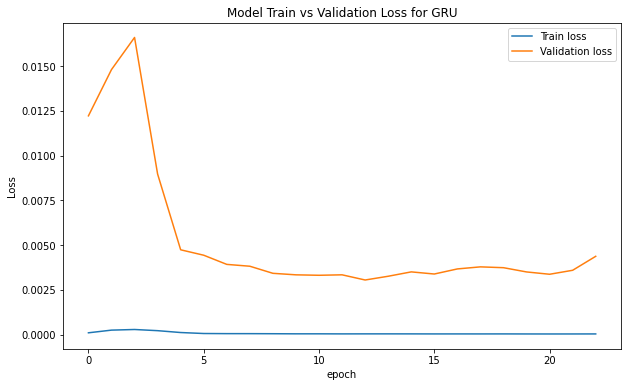

In [ ]:
def plot_loss (history, model_name):
    plt.figure(figsize = (10, 6))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Train vs Validation Loss for ' + model_name)
    plt.ylabel('Loss')
    plt.xlabel('epoch')
    plt.legend(['Train loss', 'Validation loss'], loc='upper right')
 
plot_loss (history_gru, 'GRU')

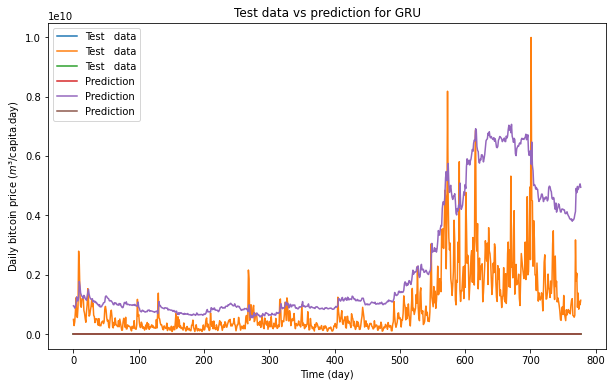

In [ ]:
# Make prediction
def prediction(model):
    prediction = model.predict(X_test)
    prediction = scaler.inverse_transform(prediction)
    return prediction
prediction_gru = prediction(model_gru)
# prediction_bilstm = prediction(model_bilstm)
# Plot test data vs prediction
def plot_future(prediction, model_name, y_test):
    plt.figure(figsize=(10, 6))
    range_future = len(prediction)
    plt.plot(np.arange(range_future), np.array(y_test), 
             label='Test   data')
    plt.plot(np.arange(range_future), 
             np.array(prediction),label='Prediction')
    plt.title('Test data vs prediction for ' + model_name)
    plt.legend(loc='upper left')
    plt.xlabel('Time (day)')
    plt.ylabel('Daily bitcoin price ($m³$/capita.day)')
 
plot_future(prediction_gru, 'GRU', y_test)

In [ ]:
prediction_gru[1][:]

array([1.0224745e+04, 9.2906982e+08, 1.3385693e+01], dtype=float32)

In [ ]:
prediction_gru.shape

(778, 3)

In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4036 entries, 0 to 4035
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   price   4036 non-null   float64
 1   volume  4036 non-null   float64
 2   gtrend  4036 non-null   float64
dtypes: float64(3)
memory usage: 94.7 KB


In [ ]:
def evaluate_prediction(predictions, actual, model_name):
    errors = predictions - actual
    mse = np.square(errors).mean()
    rmse = np.sqrt(mse)
    mae = np.abs(errors).mean()
    print(model_name + ':')
    print('Mean Absolute Error: {:.4f}'.format(mae))
    print('Root Mean Square Error: {:.4f}'.format(rmse))
    print('')
evaluate_prediction(prediction_gru, y_test, 'GRU')

GRU:
Mean Absolute Error: 463340347.5120
Root Mean Square Error: 1137095248.6009



In [ ]:
#saving model in h5 format
model_gru.save('my_model_with_gtrend.h5')

In [ ]:
X_30 = np.array((30,3))

In [ ]:
X_30.shape

(2,)

In [ ]:
# Make prediction for new data
# Masih error
def prediction(model):
    prediction = model.predict(X_30)
    prediction = scaler.inverse_transform(prediction)
    return prediction
prediction_gru = prediction(model_gru)
# prediction_bilstm = prediction(model_bilstm)
# Plot history and future
def plot_multi_step(history, prediction1):
    
    plt.figure(figsize=(15, 6))
    
    range_history = len(history)
    range_future = list(range(range_history, range_history +
                        len(prediction1)))
    plt.plot(np.arange(range_history), np.array(history), 
             label='History')
    plt.plot(range_future, np.array(prediction1),
             label='Forecasted for GRU')
    # plt.plot(range_future, np.array(prediction2),
    #          label='Forecasted for BiLSTM')
      
    plt.legend(loc='upper right')
    plt.xlabel('Time step (day)')
    plt.ylabel('Water demand (lit/day)')
        
plot_multi_step(new_data, prediction_gru)

ValueError: ignored